### Bibliotecas

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

### Implementação dos Modelos Lineares de Aprendizagem de Máquina

In [23]:
class PerceptronLA:
    def __init__(self, _X, _Y):
        self.X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.Y = _Y
    
    def fit(self):

        self.W = np.zeros(self.X.shape[1])
        indice_class_incorretas = np.arange(len(self.X))

        while (len(indice_class_incorretas) > 0):
            indice_aleatorio = np.random.choice(indice_class_incorretas)

            self.W = self.W + (self.Y[indice_aleatorio] * self.X[indice_aleatorio])

            lista_provisoria = []

            for i in range(len(self.X)):
                classificacao_atual = np.sign(self.W @ self.X[i])

                if classificacao_atual != self.Y[i]:
                    lista_provisoria.append(i)
            
            indice_class_incorretas = np.array(lista_provisoria)
    
    def predict(self, _X):
        X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.PREDICT = []

        for x in X:
            self.PREDICT.append(np.sign(self.W @ x))

        self.PREDICT = np.array(self.PREDICT)

In [24]:
class RegressaoLinear:
    def __init__(self, _X, _Y):
        self.X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.Y = _Y
    
    def fit(self):

        matriz_XtX = self.X.T @ self.X
        inversa_matriz_XtX = np.linalg.inv(matriz_XtX)
        matriz_XtY = self.X.T @ self.Y
        
        self.W = inversa_matriz_XtX @ matriz_XtY
    
    def predict(self, _X):
        X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.PREDICT = []

        for x in X:
            self.PREDICT.append(np.sign(self.W @ x))

        self.PREDICT = np.array(self.PREDICT)

In [25]:
class RegressaoLogistica:
    def __init__(self, _X, _Y, eta = 0.1, tmax = 1000, lambda_regula = 0):
        self.X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.Y = _Y
        self.eta = eta
        self.tmax = tmax
        self.lambda_regula = lambda_regula

    def fit(self):

        self.W = np.zeros(self.X.shape[1])

        for t in range(self.tmax):
            
            somatorio = np.zeros(self.X.shape[1])

            for i in range(self.X.shape[0]):
                exponencial = np.exp(self.Y[i]*(self.W @ self.X[i]))
                somatorio += (self.Y[i]*self.X[i]) / (1 + exponencial)
            
            gradiente = -(1/self.X.shape[0]) * somatorio
            gradiente += (2 * self.lambda_regula / self.X.shape[0]) * self.W

            if np.linalg.norm(gradiente) < 0.00000000000001 :
                break

            self.W = self.W - (self.eta * gradiente)

    def predict_prob(self, _X):
        self.PROB = []

        for x in _X:
            z = x @ self.W
            self.PROB.append(1 / (1 + np.exp(-z)))
            
        self.PROB = np.array(self.PROB)

    def predict(self, _X):
        X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.predict_prob(X)
        self.PREDICT = np.empty(len(self.PROB), dtype = int)

        for i in range(len(self.PROB)):
            if self.PROB[i] >= 0.5:
                self.PREDICT[i] = 1
            else:
                self.PREDICT[i] = -1

## Weight decay completo


In [26]:
def erro_binario(y_real, y_pred):
    return np.mean(np.array(y_real) != np.array(y_pred))

lambdas = [10**k for k in range(-4, 4)]  

def weight_decay_selecao(X_treino, Y_treino, X_val, Y_val, lambdas, eta=0.1, tmax=1000):
    modelos = []
    erros_val = []

    for lam in lambdas:
        modelo = RegressaoLogistica(X_treino, Y_treino, eta=eta, tmax=tmax, lambda_regula=lam)
        modelo.fit()
        
        modelo.predict(X_val)
        erro = erro_binario(Y_val, modelo.PREDICT)
        
        modelos.append(modelo)
        erros_val.append(erro)
        
        print(f"Lambda = {lam:<10} | Erro validação = {erro:.4f}")
    
    return modelos, erros_val


def weight_decay_completo(X_treino, Y_treino, X_val, Y_val, X_teste, Y_teste, lambdas, eta=0.1, tmax=1000):
    
    _, erros_val = weight_decay_selecao(X_treino, Y_treino, X_val, Y_val, lambdas, eta, tmax)
    
    menor_erro = erros_val[0]
    melhor_idx = 0
    for i in range(1, len(erros_val)):
        if erros_val[i] < menor_erro:
            menor_erro = erros_val[i]
            melhor_idx = i
    
    melhor_lambda = lambdas[melhor_idx]
    
    X_treino_final = np.vstack((X_treino, X_val))
    Y_treino_final = np.concatenate((Y_treino, Y_val))
    
    modelo_final = RegressaoLogistica(X_treino_final, Y_treino_final, eta=eta, tmax=tmax, lambda_regula=melhor_lambda)
    modelo_final.fit()
    
    modelo_final.predict(X_teste)
    erro_teste = erro_binario(Y_teste, modelo_final.PREDICT)
    
    return modelo_final, melhor_lambda, erros_val, erro_teste

### Classificação dos Dígitos 1x5

Separando train_redu em treino (80%) e validação (20%) antes de filtrar. Depois filtrando os dígitos 1 e 5 em cada conjunto (treino, validação e teste) e normalizando

In [27]:
train_redu = pd.read_csv("DatasetProjeto1/train_redu.csv")
test_redu = pd.read_csv("DatasetProjeto1/test_redu.csv")

train_redu_misturado = train_redu.sample(frac=1, random_state=42).reset_index(drop=True)

tamanho_treino = int(0.8 * len(train_redu_misturado))

train_wd = train_redu_misturado.iloc[:tamanho_treino]
val_wd = train_redu_misturado.iloc[tamanho_treino:]

train1x5 = train_wd[train_wd["label"].isin([1,5])].copy()
val1x5 = val_wd[val_wd["label"].isin([1,5])].copy()
test1x5 = test_redu[test_redu["label"].isin([1,5])].copy()

scaler = MinMaxScaler()

train1x5[["intensidade", "simetria"]] = scaler.fit_transform(train1x5[["intensidade", "simetria"]])
val1x5[["intensidade", "simetria"]] = scaler.transform(val1x5[["intensidade", "simetria"]])
test1x5[["intensidade", "simetria"]] = scaler.transform(test1x5[["intensidade", "simetria"]])

Plotando os dados de treino

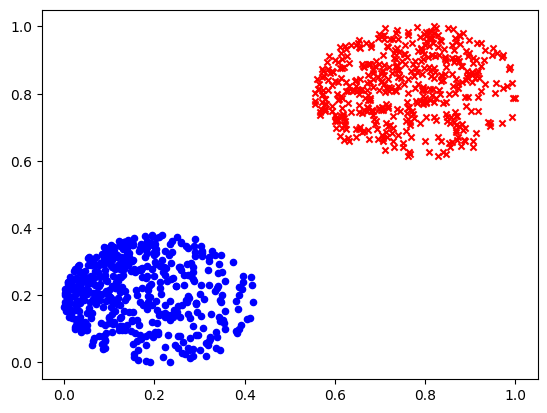

In [28]:
label1 = train1x5[train1x5["label"] == 1]
label5 = train1x5[train1x5["label"] == 5]

plt.scatter(label1["intensidade"], label1["simetria"], color='blue', marker='o', s=20)
plt.scatter(label5["intensidade"], label5["simetria"], color='red', marker='x', s=20)

Construindo os vetores X e Y (treino, validação e teste) com +1 para label = 1 e -1 para label = 5

In [29]:
X_treino = train1x5[["intensidade", "simetria"]].to_numpy()
Y_treino = train1x5["label"].map({1: 1, 5: -1}).to_numpy()

X_val = val1x5[["intensidade", "simetria"]].to_numpy()
Y_val = val1x5["label"].map({1: 1, 5: -1}).to_numpy()

X_teste = test1x5[["intensidade", "simetria"]].to_numpy()
Y_teste = test1x5["label"].map({1: 1, 5: -1}).to_numpy()

Treinando PLA e Regressão Linear com treino, e Regressão Logística

In [30]:
PLAclass = PerceptronLA(X_treino, Y_treino)
RLclass = RegressaoLinear(X_treino, Y_treino)
RLOclass = RegressaoLogistica(X_treino, Y_treino)

PLAclass.fit()
RLclass.fit()
RLOclass.fit()

In [31]:
print(PLAclass.W)
print(RLclass.W)
print(RLOclass.W)

[ 1.         -0.83081296 -1.10811825]
[ 1.5502447  -1.36758528 -1.78495018]
[ 3.68739606 -3.93856756 -3.97224897]


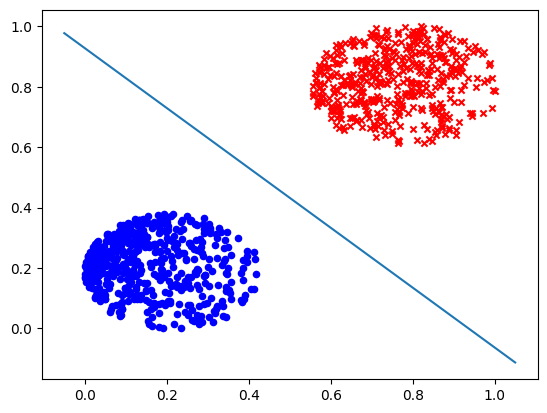

In [32]:
plt.scatter(label1["intensidade"], label1["simetria"], color='blue', marker='o', s=20)
plt.scatter(label5["intensidade"], label5["simetria"], color='red', marker='x', s=20)

b  = RLOclass.W[0]
w1 = RLOclass.W[1]
w2 = RLOclass.W[2]

x = np.linspace(plt.xlim()[0], plt.xlim()[1], 200)

y = -(w1/w2)*x - (b/w2)

plt.plot(x, y)
plt.show()